<a href="https://colab.research.google.com/github/Subikesh/Sentiment-Analysis/blob/master/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

In this project we'll get the dataset containing the reviews from amazon for baby products and their corresponding ratings given by the users. 
We will clean the unstructured data to structured data by encoding techniques.
We will train many classification models to train the dataset and predict the sentiment of the customer in each reviews.
Then finally, we will find the best model by accuracy of the models and train the final model for the dataset.

In [0]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns',5)

# Loading Data

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The dataset amazon-baby.csv contains a larger dataset than the one used here. This is used because the algorithms takes lot of time in the larger dataset.

In [29]:
# amazon_data = pd.read_csv('/content/gdrive/My Drive/colab_input/amazon_baby.csv')
amazon_data = pd.read_csv('/content/gdrive/My Drive/colab_input/amazon_baby_subset.csv')
amazon_data.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


Number of reviews for each rating in the dataset is shown below. Since this is a compact version of the original dataset, all the reviews with rating 3 are removed.

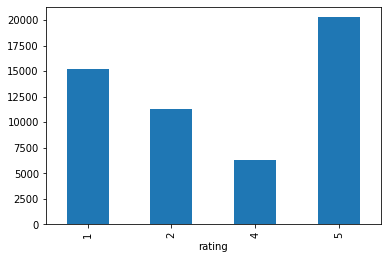

In [30]:
amazon_data.groupby('rating').size().plot.bar()

## Cleaning Data

Let's create a sentiment column with sentiments as per the ratings given and remove all the reviews with rating 3 because intermediate reviews cannot be considered as positive or negative review

In [31]:
print('Data before droping ', amazon_data.shape)
amazon_data = amazon_data[amazon_data['rating'] != 3]
print("Data after droping rows", amazon_data.shape)

Data before droping  (53072, 4)
Data after droping rows (53072, 4)


In [32]:
amazon_data['sentiment'] = amazon_data['rating'].apply(lambda r: +1 if r>3 else -1)
amazon_data.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [33]:
# Droping unwanted features to clean up space
amazon_data = amazon_data.drop(columns = ['rating', 'name'])
amazon_data.head()

,review,sentiment
0,All of my kids have cried non-stop when I trie...,1
1,We wanted to get something to keep track of ou...,1
2,My daughter had her 1st baby over a year ago. ...,1
3,"One of baby's first and favorite books, and it...",1
4,Very cute interactive book! My son loves this ...,1


The important words from the reviews are taked as a json file, so that those features can be used to calculate the sentiment

In [34]:
import json
with open('/content/gdrive/My Drive/colab_input/important_words.json', 'r') as f:
    important_words = json.load(f)
important_words = [str(s) for s in important_words]
print(len(important_words), "words imported from json")

193 words imported from json


In [35]:
import string 

# Removing the punctuations from the reviews so there wont be any problem in retrieving the words
def remove_punctuations(text):
    translator = text.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text

amazon_data = amazon_data.dropna()
amazon_data['clean_review'] = amazon_data['review'].apply(remove_punctuations)
clean_data = amazon_data.drop('review', axis=1)
clean_data.head()

,sentiment,clean_review
0,1,All of my kids have cried nonstop when I tried...
1,1,We wanted to get something to keep track of ou...
2,1,My daughter had her 1st baby over a year ago S...
3,1,One of babys first and favorite books and it i...
4,1,Very cute interactive book My son loves this b...


## Encoding for classification
Creating features for important words from the *clean_review* column so they 
can be used for creating the models.

In [36]:
for word in important_words:
    clean_data[word] = clean_data['clean_review'].apply(lambda text: text.split().count(word))
final_data = clean_data.drop('clean_review', 1)
final_data.head(), final_data.shape

(   sentiment  baby  ...  almost  either
 0          1     0  ...       0       0
 1          1     0  ...       0       0
 2          1     1  ...       0       0
 3          1     0  ...       0       0
 4          1     0  ...       0       0
 
 [5 rows x 194 columns], (52831, 194))

## Splitting train and test data


In [38]:
from sklearn.model_selection import train_test_split
X = final_data[important_words]
y = final_data['sentiment']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)
train_X.shape, test_X.shape

((42264, 193), (10567, 193))

# Training models

## Import libraries

In [0]:
# Models
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

An **accuracy table** is created which holds the values of accuracies of all the models trained.<br>
A utility function is created to calculate the metrics for each model and add it to the accuracy table.



In [0]:
accuracy_table = pd.DataFrame(columns=['precision_score','recall_score', 'f1_score', 'accuracy_score'])

def append_accuracy(model, prediction, true_val, label):
    acc = []
    acc.append(model.precision_score(prediction, true_val))
    acc.append(model.recall_score(prediction, true_val))
    acc.append(model.f1_score(prediction, true_val))
    acc.append(model.accuracy_score(prediction, true_val))
    accuracy_table.loc[label] = acc

## Logistic Regression


In [0]:
params = {'C': [0.001, 0.01, 0.1, 1, 10]}
model = GridSearchCV(LogisticRegression(solver='liblinear'),param_grid=params, cv=5)
model.fit(train_X, train_y)

